In [1]:
#!/usr/bin/env python3

# Menyesuaikan path agar dapat mengimpor modul dari direktori utama (induk)
# tanpa mengubah struktur direktori proyek
import sys
sys.path.append('..')

# Mengimpor file module untuk melakukan sync semua file
# pada direktori utama (induk)
import module

Melakukan validasi _Optical Flow_ dengan _TVL1_ untuk melakukan ekstraksi optical flow

In [2]:
# Memvalidasi apakah OpenCV yang terinstal mendukung pemrosesan dengan CUDA
import cv2

# Jika CUDA tersedia, maka akan mencetak "Cuda available"
# Jika tidak, maka akan mencetak "Cuda not available"
print("Cuda available " if cv2.cuda.getCudaEnabledDeviceCount() else "Cuda not available")

Cuda available 


Membuat abstraksi untuk ekstraksi optical flow menggunakan TV-L1 yang mendukung support pemrosesan menggunakan GPU

In [3]:
import numpy as np


class Image:

    def grayscale(self, image: np.ndarray) -> np.ndarray:
        """
        Mengonversi gambar input menjadi format grayscale.

        Args:
            image (numpy.ndarray): Citra input .

        Returns:
            numpy.ndarray: Citra grayscale.

        Raises:
            None
        """

        # Memastikan input adalah image yang valid.
        if not isinstance(image, np.ndarray) or image is None:
            raise ValueError("Input image is invalid.")

        # Validasi dan konversi gambar ke format grayscale
        # Jika gambar berwarna (BGR) atau (RGB), konversi ke grayscale
        if len(image.shape) == 3 and image.shape[2] == 3: 
            return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Jika gambar sudah dalam format grayscale, kembalikan langsung
        elif len(image.shape) == 2: return image

        # Jika format gambar tidak dikenali, kembalikan dengan raise ValueError
        else:
            raise ValueError("Input image must be either a grayscale or BGR image.")

In [4]:
import cv2


class Video:

    def __init__(self, video_path: str) -> None:
        """
        Inisialisasi objek Video dengan path video yang diberikan.

        Args:
            video_path (str): Path ke file video.

        Raises:
            ValueError: Jika file video tidak dapat dibuka.
        """
        
        # Menyimpan path video dan membuka file video menggunakan OpenCV
        self.video_path = video_path

        # Membuka file video menggunakan OpenCV
        self.capture = cv2.VideoCapture(video_path)

        # Jika file video tidak dapat dibuka
        # Kembalikan dengan raise ValueError
        if not self.capture.isOpened():
            raise ValueError(f"Cannot open video file: {video_path}")


    def map(self, func: callable) -> list:
        """
        Menerapkan fungsi pada setiap pasangan frame berturut-turut dalam video.

        Args:
            func (callable): Fungsi yang akan diterapkan pada setiap pasangan frame.
                             Fungsi ini harus menerima dua argumen (frame sebelumnya dan frame saat ini)
                             dan mengembalikan hasil yang diinginkan.

        Returns:
            list: Daftar hasil yang dikembalikan oleh fungsi untuk setiap pasangan frame.
        """
        results = []
        frame_idx = 0

        ret, prev_frame = self.capture.read()
        if not ret:
            self.capture.release()
            return results

        while True:
            ret, curr_frame = self.capture.read()
            if not ret:
                break

            result = func(prev_frame, curr_frame, frame_idx)
            results.append(result)

            prev_frame = curr_frame
            frame_idx += 1

        self.capture.release()
        return results


In [5]:
import cv2
import numpy as np


class TVL1:

    # Image instance untuk pemrosesan gambar
    image: Image = None

    def __init__(self):
        
        # Validasi apakah CUDA tersedia pada sistem
        # Jika tersedia, gunakan versi GPU untuk pemrosesan optical flow TVL1
        if hasattr(cv2, "cuda") and cv2.cuda.getCudaEnabledDeviceCount() > 0:
            
            # Jika CUDA mendukung TVL1 maka inisialisasi model dengan itu
            if hasattr(cv2.cuda, "OpticalFlowDual_TVL1_create"):
                self.tvl1           = cv2.cuda.OpticalFlowDual_TVL1_create()
                self.gpumat_prev    = cv2.cuda_GpuMat()
                self.gpumat_next    = cv2.cuda_GpuMat()
                self.gpumat_flow    = cv2.cuda_GpuMat()

        else:

            # Jika tidak, gunakan versi CPU untuk pemrosesan optical flow TVL1
            self.tvl1 = cv2.optflow.DualTVL1OpticalFlow_create()

        # Menyesuaikan parameter TVL1 untuk mendapatkan
        # sensitivitas dan kinerja yang optimal
        self.tvl1.setLambda(0.15)
        self.tvl1.setTheta(0.3)
        self.tvl1.setTau(0.25)

        # Menginisialisasi atribut untuk menyimpan hasil optical flow
        self.flow = None

        # Menginisialisasi instance Image untuk pemrosesan gambar
        self.image = Image()


    def compute(self, prev: np.ndarray, next: np.ndarray):
        """
        Menghitung optical flow antara dua frame menggunakan algoritma TV-L1.

        Args:
            prev (numpy.ndarray): Frame sebelum.
            next (numpy.ndarray): Frame saat ini.

        Returns:
            numpy.ndarray: Optical flow yang dihitung.

        Raises:
            ValueError: Jika dimensi frame input tidak sesuai.
        """

        if prev.shape != next.shape:
            raise ValueError("Input frames must have the same dimensions.")

        # Memastikan kedua frame dalam format grayscale
        # Format ini diperlukan untuk perhitungan optical flow
        grayscalled_prev = self.image.grayscale(prev)
        grayscalled_next = self.image.grayscale(next)

        # Menghitung optical flow menggunakan TV-L1
        # Memanfaatkan GPU jika tersedia untuk mempercepat perhitungan
        if hasattr(cv2, "cuda") and cv2.cuda.getCudaEnabledDeviceCount() > 0 and hasattr(cv2.cuda, "OpticalFlowDual_TVL1_create"):

            # Mengunggah frame grayscale ke GPU
            self.gpumat_prev.upload(grayscalled_prev)
            self.gpumat_next.upload(grayscalled_next)

            # Menghitung optical flow di GPU
            self.gpumat_flow = self.tvl1.calc(self.gpumat_prev, self.gpumat_next, self.gpumat_flow)
            flow = self.gpumat_flow.download()

            # Membersihkan memori GPU
            self.gpumat_prev, self.gpumat_next, self.gpumat_next, self.gpumat_prev

        else:

            # Menghitung optical flow di CPU
            flow = self.tvl1.calc(grayscalled_prev, grayscalled_next, None)

        # Menyimpan hasil optical flow dalam atribut kelas
        self.flow = flow

        return flow

Menyiapkan data source untuk pengujian ekstraksi optical flow

In [6]:
import os
from pathlib import Path


# Sumber data utama
BASE_DATASOURCE_PATH= os.path.join(Path.home().as_posix(), "datasets", "primary-converted")

# Sumber data kelas yang diambil pada 08/12/2025
# Terdapat dua tipe data (before dan after)
BASE_SUBJECT_GROUP_08122025_BEFORE_AFTER_PATH=os.path.join(BASE_DATASOURCE_PATH, "8-12-2025")

# Sumber data kelas yang diambil pada 09/12/2025
# Terdapat dua tipe data (before dan after)
BASE_SUBJECT_GROUP_09122025_BEFORE_AFTER_PATH=os.path.join(BASE_DATASOURCE_PATH, "9-12-2025")

print("Datasource path successfully set.")

Datasource path successfully set.


Mencoba melakukan ekstraksi optical flow menggunakan data yang sudah disiapkan

In [ ]:
import os
import numpy as np
from src.face.modules.face_landmark import FaceLandmark
from src.face.modules.face_aligner import FaceAligner


SUBJECT_ONE_BEFORE_PATH=os.path.join(BASE_SUBJECT_GROUP_08122025_BEFORE_AFTER_PATH, "aaisyah_nursalsabiil_ni_patriarti_1765168488512")
SUBJECT_ONE_BEFORE_Q1_PATH=os.path.join(SUBJECT_ONE_BEFORE_PATH, "q5")
SUBJECT_ONE_BEFORE_Q1_REALSENSE_PATH=os.path.join(SUBJECT_ONE_BEFORE_Q1_PATH, "answer_5_e1e6b3e5-a2d1-4832-a1fc-e03673252751_sec.avi")

subone = Video(SUBJECT_ONE_BEFORE_Q1_REALSENSE_PATH)

tvl1 = TVL1()

face_landmark = FaceLandmark()

face_aligner = FaceAligner()

magnitudes = []

def process(prev_frame: np.ndarray, current_frame: np.ndarray, *args, **kwargs):
    
    # Mendeteksi dan memotong wajah pada kedua frame
    prev_frame_landmarks = face_landmark.detect(prev_frame)
    next_frame_landmarks = face_landmark.detect(current_frame)

    cropped_prev_frame = face_landmark.crop(image=prev_frame, landmarks=prev_frame_landmarks)
    cropped_next_frame = face_landmark.crop(image=current_frame, landmarks=next_frame_landmarks)

    # Menyelaraskan posisi wajah dengan melakukan alignment
    # aligned_cropped_prev_frame = face_aligner.align(cropped_prev_frame, prev_frame_landmarks)
    # aligned_cropped_next_frame = face_aligner.align(cropped_next_frame, next_frame_landmarks)

    # Menghitung optical flow antara dua frame
    flow = tvl1.compute(cropped_prev_frame, cropped_next_frame)

    # Mengambil nilai pergerakan dari sumbu x dan y
    # x -> horizontal
    # y -> vertical
    dx = flow[..., 0]
    dy = flow[..., 1]

    # Menghitung nilai magnitudo dari pergerakan menggunakan rumus Pythagoras
    magnitude = np.sqrt(dx**2 + dy**2)

    # Menghitung rata-rata magnitudo
    mean_magnitude = np.mean(magnitude)
    magnitudes.append(mean_magnitude)


subone.map(process)

Memvisualisasikan output magnitudo dari optical flow dengan proses smoothing menggunakan savgol filter

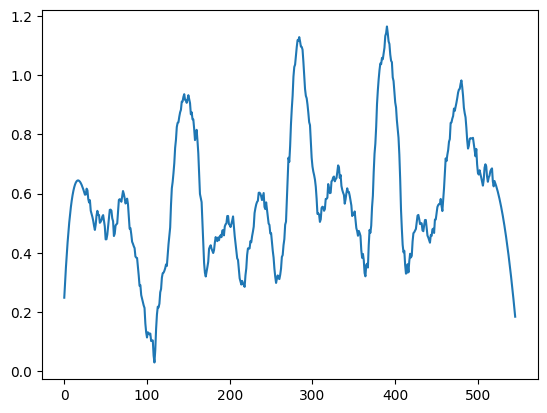

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


filtered_magnitudes = savgol_filter(magnitudes, 51, 3)

plt.plot(filtered_magnitudes)
plt.show()

Mengolah dan mengekstraksi optical flow pada batch subject

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


classone_path_list = glob.glob(os.path.join(BASE_SUBJECT_GROUP_08122025_BEFORE_AFTER_PATH, "**", "*.avi"),
                               recursive=True)

classtwo_path_list = glob.glob(os.path.join(BASE_SUBJECT_GROUP_09122025_BEFORE_AFTER_PATH, "**", "*.avi"),
                               recursive=True)

print(classtwo_path_list)

class_path_list = classone_path_list + classtwo_path_list


non_anxiety_paths = [
    # "key_firdausi_alfarel",
    # "akhmad_aakhif_athallah",
    # "hizkia_elsadanta",
    # "ahmad_rifqi_hendriansyah",
    # "haikal_muhammad_rafli",
]

anxiety_paths = [
    # "aaisyah_nursalsabiil_ni_patriarti",
    # "dika_arie_arrifky",
    # "fabian_ananda_merdana",
    # "muhammad_khalid_atthoriq",
    # "nova_eliza_maharani",
    "achmad_anfasa_rabbany"
]

def process_frame(path: str):

    video = Video(path)
    magnitudes = []

    first_frame = None

    def process(prev_frame: np.ndarray, current_frame: np.ndarray, frame_index: int):

        # Mendeteksi dan memotong wajah pada kedua frame
        prev_frame_landmarks = face_landmark.detect(prev_frame)
        next_frame_landmarks = face_landmark.detect(current_frame)

        cropped_prev_frame = face_landmark.crop(image=prev_frame, landmarks=prev_frame_landmarks)
        cropped_next_frame = face_landmark.crop(image=current_frame, landmarks=next_frame_landmarks)

        # Ambil frame pertama untuk plot nanti
        if frame_index == 0:
            nonlocal first_frame
            first_frame = cropped_prev_frame

        # Menghitung optical flow antara dua frame
        flow = tvl1.compute(cropped_prev_frame, cropped_next_frame)

        # Mengambil nilai pergerakan dari sumbu x dan y
        # x -> horizontal
        # y -> vertical
        dx = flow[..., 0]
        dy = flow[..., 1]

        # Menghitung nilai magnitudo dari pergerakan menggunakan rumus Pythagoras
        magnitude = np.sqrt(dx**2 + dy**2)

        # Menghitung rata-rata magnitudo
        mean_magnitude = np.mean(magnitude)
        magnitudes.append(mean_magnitude)

    video.map(process)

    filtered_magnitudes = savgol_filter(magnitudes, 51, 3)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    axes[0].set_title("First Frame")
    axes[0].axis("off")

    axes[1].plot(filtered_magnitudes)
    axes[1].set_title("Optical Flow Magnitude Over Time")
    axes[1].set_xlabel("Frame Index")
    axes[1].set_ylabel("Filtered Magnitude")

    fig.suptitle(f"Optical Flow Analysis for {os.path.basename(path)}")
    plt.tight_layout()
    plt.show()


filtered_non_anxiety_paths = sorted([
    p for p in class_path_list
    if any(name in p for name in non_anxiety_paths)
])

filtered_anxiety_paths = sorted([
    p for p in class_path_list
    if any(name in p for name in anxiety_paths)
])

for path in filtered_non_anxiety_paths:
    process_frame(path)

for path in filtered_anxiety_paths:
    process_frame(path)

Menerapkan ekstraksi region of interest berdasarkan region of interest (RoI)

In [9]:
import cv2
from src.face.modules.face_landmark import FaceLandmark
from src.face.modules.face_roi import FaceRoiPoints, FaceRoiSizes


cap = cv2.VideoCapture(SUBJECT_ONE_BEFORE_Q1_REALSENSE_PATH)

ret, prev_frame = cap.read()   # frame 0
ret, curr_frame = cap.read()   # frame 1

if not ret:
    raise ValueError("Cannot read video file.")

face_landmark = FaceLandmark()

prev_frame_landmarks = face_landmark.detect(prev_frame)
curr_frame_landmarks = face_landmark.detect(curr_frame)

cropped_left_eye_prev_frame, left_eye_roi_mask              = face_landmark.crop_roi(image=prev_frame,
                                                                                     landmark_result=prev_frame_landmarks,
                                                                                     roi_points=FaceRoiPoints.LEFT_EYE_POINTS,
                                                                                     target_size=FaceRoiSizes.EYE_SIZE)

cropped_right_eye_prev_frame, right_eye_roi_mask            = face_landmark.crop_roi(image=prev_frame,
                                                                                     landmark_result=prev_frame_landmarks,
                                                                                     roi_points=FaceRoiPoints.RIGHT_EYE_POINTS,
                                                                                     target_size=FaceRoiSizes.EYE_SIZE)

cropped_left_eyebrow_prev_frame, left_eyebrow_roi_mask     = face_landmark.crop_roi(image=prev_frame,
                                                                                    landmark_result=prev_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.LEFT_EYEBROW_POINTS,
                                                                                    target_size=FaceRoiSizes.EYEBROW_SIZE)

cropped_right_eyebrow_prev_frame, right_eyebrow_roi_mask   = face_landmark.crop_roi(image=prev_frame,
                                                                                    landmark_result=prev_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.RIGHT_EYEBROW_POINTS,
                                                                                    target_size=FaceRoiSizes.EYEBROW_SIZE)

cropped_lips_prev_frame, lips_roi_mask                     = face_landmark.crop_roi(image=prev_frame,
                                                                                    landmark_result=prev_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.LIPS_POINTS,
                                                                                    target_size=FaceRoiSizes.LIPS_SIZE)

cropped_left_eye_curr_frame, left_eye_roi_mask             = face_landmark.crop_roi(image=curr_frame,
                                                                                    landmark_result=curr_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.LEFT_EYE_POINTS,
                                                                                    target_size=FaceRoiSizes.EYE_SIZE)

cropped_right_eye_curr_frame, right_eye_roi_mask           = face_landmark.crop_roi(image=curr_frame,
                                                                                    landmark_result=curr_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.RIGHT_EYE_POINTS,
                                                                                    target_size=FaceRoiSizes.EYE_SIZE)

cropped_left_eyebrow_curr_frame, left_eyebrow_roi_mask     = face_landmark.crop_roi(image=curr_frame,
                                                                                    landmark_result=curr_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.LEFT_EYEBROW_POINTS,
                                                                                    target_size=FaceRoiSizes.EYEBROW_SIZE)

cropped_right_eyebrow_curr_frame, right_eyebrow_roi_mask   = face_landmark.crop_roi(image=curr_frame,
                                                                                    landmark_result=curr_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.RIGHT_EYEBROW_POINTS,
                                                                                    target_size=FaceRoiSizes.EYEBROW_SIZE)

cropped_lips_curr_frame, lips_roi_mask                     = face_landmark.crop_roi(image=curr_frame,
                                                                                    landmark_result=curr_frame_landmarks,
                                                                                    roi_points=FaceRoiPoints.LIPS_POINTS,
                                                                                    target_size=FaceRoiSizes.LIPS_SIZE)

tvl1 = TVL1()

flow_left_eye       = tvl1.compute(cropped_left_eye_prev_frame, cropped_left_eye_curr_frame)
flow_right_eye      = tvl1.compute(cropped_right_eye_prev_frame, cropped_right_eye_curr_frame)
flow_left_eyebrow   = tvl1.compute(cropped_left_eyebrow_prev_frame, cropped_left_eyebrow_curr_frame)
flow_right_eyebrow  = tvl1.compute(cropped_right_eyebrow_prev_frame, cropped_right_eyebrow_curr_frame)
flow_lips           = tvl1.compute(cropped_lips_prev_frame, cropped_lips_curr_frame)


flow_left_eye[..., 0]    *= (left_eye_roi_mask > 0)
flow_left_eye[..., 1]    *= (left_eye_roi_mask > 0)

flow_right_eye[..., 0]   *= (right_eye_roi_mask > 0)
flow_right_eye[..., 1]   *= (right_eye_roi_mask > 0)

flow_left_eyebrow[..., 0]    *= (left_eyebrow_roi_mask > 0)
flow_left_eyebrow[..., 1]    *= (left_eyebrow_roi_mask > 0)

flow_right_eyebrow[..., 0]   *= (right_eyebrow_roi_mask > 0)
flow_right_eyebrow[..., 1]   *= (right_eyebrow_roi_mask > 0)

flow_lips[..., 0]    *= (lips_roi_mask > 0)
flow_lips[..., 1]    *= (lips_roi_mask > 0)


magnitude_left_eye      = np.sqrt(flow_left_eye[..., 0]**2 + flow_left_eye[..., 1]**2)
magnitude_right_eye     = np.sqrt(flow_right_eye[..., 0]**2 + flow_right_eye[..., 1]**2)
magnitude_left_eyebrow  = np.sqrt(flow_left_eyebrow[..., 0]**2 + flow_left_eyebrow[..., 1]**2)
magnitude_right_eyebrow = np.sqrt(flow_right_eyebrow[..., 0]**2 + flow_right_eyebrow[..., 1]**2)
magnitude_lips          = np.sqrt(flow_lips[..., 0]**2 + flow_lips[..., 1]**2)

mean_magnitude_left_eye      = np.mean(magnitude_left_eye)
mean_magnitude_right_eye     = np.mean(magnitude_right_eye)
mean_magnitude_left_eyebrow  = np.mean(magnitude_left_eyebrow)
mean_magnitude_right_eyebrow = np.mean(magnitude_right_eyebrow)
mean_magnitude_lips          = np.mean(magnitude_lips)

W0000 00:00:1770125326.008118    9378 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1770125326.025167    9381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770125326.060759    9390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [10]:
print("Mean Magnitude Left Eye:", mean_magnitude_left_eye)
print("Mean Magnitude Right Eye:", mean_magnitude_right_eye)
print("Mean Magnitude Left Eyebrow:", mean_magnitude_left_eyebrow)
print("Mean Magnitude Right Eyebrow:", mean_magnitude_right_eyebrow)
print("Mean Magnitude Lips:", mean_magnitude_lips)

Mean Magnitude Left Eye: 0.03181787
Mean Magnitude Right Eye: 0.33861527
Mean Magnitude Left Eyebrow: 0.109443925
Mean Magnitude Right Eyebrow: 0.016536264
Mean Magnitude Lips: 0.013614784


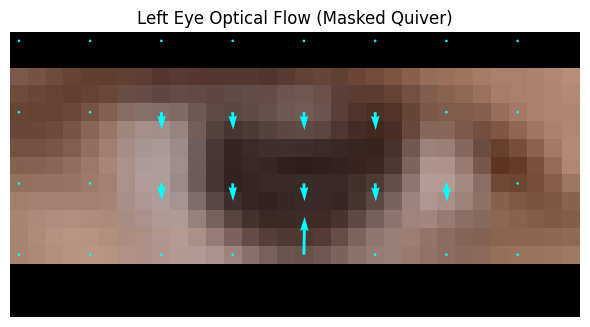

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


flow = flow_right_eye
roi_img = cropped_right_eye_prev_frame
roi_mask = right_eye_roi_mask

dx = flow[..., 0]
dy = flow[..., 1]
magnitude = np.sqrt(dx**2 + dy**2)

step = 4
scale = 1

h, w = roi_img.shape[:2]
Y, X = np.mgrid[0:h:step, 0:w:step]

U = dx[::step, ::step]
V = dy[::step, ::step]
M = roi_mask[::step, ::step] > 0

U = np.where(M, U, 0)
V = np.where(M, V, 0)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
ax.quiver(
    X, Y,
    U, V,
    angles="xy",
    scale_units="xy",
    scale=scale,
    color="cyan",
    width=0.005
)

ax.set_title("Left Eye Optical Flow (Masked Quiver)")
ax.axis("off")

plt.tight_layout()
plt.show()



Mendapatkan keseluruhan magnitudo pada runtutan cerita video

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from src.face.modules.face_landmark import FaceLandmark
from src.face.modules.face_roi import FaceRoiPoints, FaceRoiSizes



classone_path_list = glob.glob(os.path.join(BASE_SUBJECT_GROUP_08122025_BEFORE_AFTER_PATH, "**", "*.avi"), recursive=True)

classtwo_path_list = glob.glob(os.path.join(BASE_SUBJECT_GROUP_09122025_BEFORE_AFTER_PATH, "**", "*.avi"), recursive=True)

class_path_list = classone_path_list + classtwo_path_list

non_anxiety_paths = [
    # "key_firdausi_alfarel",
    # "akhmad_aakhif_athallah",
    # "hizkia_elsadanta",
    # "ahmad_rifqi_hendriansyah",
    "haikal_muhammad_rafli",
]

anxiety_paths = [
    # "aaisyah_nursalsabiil_ni_patriarti",
    # "dika_arie_arrifky",
    # "fabian_ananda_merdana",
    # "muhammad_khalid_atthoriq",
    # "nova_eliza_maharani",
    # "achmad_anfasa_rabbany"
]


face_landmark = FaceLandmark()

tvl1 = TVL1()

magnitudes = []

def process(prev_frame: np.ndarray, current_frame: np.ndarray, frame_index: int):
    
    prev_frame_landmarks = face_landmark.detect(prev_frame)
    curr_frame_landmarks = face_landmark.detect(current_frame)

    # Membuat potongan berdasarkan RoI
    cropped_left_eye_prev_frame, left_eye_roi_mask              = face_landmark.crop_roi(image=prev_frame,
                                                                                         landmark_result=prev_frame_landmarks,
                                                                                         roi_points=FaceRoiPoints.LEFT_EYE_POINTS,
                                                                                         target_size=FaceRoiSizes.EYE_SIZE) 
    
    cropped_right_eye_prev_frame, right_eye_roi_mask            = face_landmark.crop_roi(image=prev_frame,
                                                                                         landmark_result=prev_frame_landmarks,
                                                                                         roi_points=FaceRoiPoints.RIGHT_EYE_POINTS,
                                                                                         target_size=FaceRoiSizes.EYE_SIZE)
    
    cropped_left_eye_curr_frame, left_eye_roi_mask             = face_landmark.crop_roi(image=current_frame,
                                                                                         landmark_result=curr_frame_landmarks,
                                                                                         roi_points=FaceRoiPoints.LEFT_EYE_POINTS,
                                                                                         target_size=FaceRoiSizes.EYE_SIZE)
    
    cropped_right_eye_curr_frame, right_eye_roi_mask           = face_landmark.crop_roi(image=current_frame,
                                                                                         landmark_result=curr_frame_landmarks,
                                                                                         roi_points=FaceRoiPoints.RIGHT_EYE_POINTS,
                                                                                         target_size=FaceRoiSizes.EYE_SIZE)
    
    cropped_left_eyebrow_prev_frame, left_eyebrow_roi_mask     = face_landmark.crop_roi(image=prev_frame,
                                                                                        landmark_result=prev_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.LEFT_EYEBROW_POINTS,
                                                                                        target_size=FaceRoiSizes.EYEBROW_SIZE)
    
    cropped_right_eyebrow_prev_frame, right_eyebrow_roi_mask   = face_landmark.crop_roi(image=prev_frame,
                                                                                        landmark_result=prev_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.RIGHT_EYEBROW_POINTS,
                                                                                        target_size=FaceRoiSizes.EYEBROW_SIZE)
    
    cropped_left_eyebrow_curr_frame, left_eyebrow_roi_mask     = face_landmark.crop_roi(image=current_frame,
                                                                                        landmark_result=curr_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.LEFT_EYEBROW_POINTS,
                                                                                        target_size=FaceRoiSizes.EYEBROW_SIZE)
    
    cropped_right_eyebrow_curr_frame, right_eyebrow_roi_mask   = face_landmark.crop_roi(image=current_frame,
                                                                                        landmark_result=curr_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.RIGHT_EYEBROW_POINTS,
                                                                                        target_size=FaceRoiSizes.EYEBROW_SIZE)
    
    cropped_lips_prev_frame, lips_roi_mask                     = face_landmark.crop_roi(image=prev_frame,
                                                                                        landmark_result=prev_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.LIPS_POINTS,
                                                                                        target_size=FaceRoiSizes.LIPS_SIZE)
    
    cropped_lips_curr_frame, lips_roi_mask                     = face_landmark.crop_roi(image=current_frame,
                                                                                        landmark_result=curr_frame_landmarks,
                                                                                        roi_points=FaceRoiPoints.LIPS_POINTS,
                                                                                        target_size=FaceRoiSizes.LIPS_SIZE)

    
    flow_left_eye = tvl1.compute(cropped_left_eye_prev_frame, cropped_left_eye_curr_frame)
    flow_right_eye = tvl1.compute(cropped_right_eye_prev_frame, cropped_right_eye_curr_frame)
    flow_left_eyebrow = tvl1.compute(cropped_left_eyebrow_prev_frame, cropped_left_eyebrow_curr_frame)
    flow_right_eyebrow = tvl1.compute(cropped_right_eyebrow_prev_frame, cropped_right_eyebrow_curr_frame)
    flow_lips = tvl1.compute(cropped_lips_prev_frame, cropped_lips_curr_frame)

    flow_left_eye[..., 0]    *= (left_eye_roi_mask > 0)
    flow_left_eye[..., 1]    *= (left_eye_roi_mask > 0)

    flow_right_eye[..., 0]   *= (right_eye_roi_mask > 0)
    flow_right_eye[..., 1]   *= (right_eye_roi_mask > 0)

    flow_left_eyebrow[..., 0]    *= (left_eyebrow_roi_mask > 0)
    flow_left_eyebrow[..., 1]    *= (left_eyebrow_roi_mask > 0)

    flow_right_eyebrow[..., 0]   *= (right_eyebrow_roi_mask > 0)
    flow_right_eyebrow[..., 1]   *= (right_eyebrow_roi_mask > 0)

    flow_lips[..., 0]    *= (lips_roi_mask > 0)
    flow_lips[..., 1]    *= (lips_roi_mask > 0)


    magnitude_left_eye      = np.sqrt(flow_left_eye[..., 0]**2 + flow_left_eye[..., 1]**2)
    magnitude_right_eye     = np.sqrt(flow_right_eye[..., 0]**2 + flow_right_eye[..., 1]**2)
    magnitude_left_eyebrow  = np.sqrt(flow_left_eyebrow[..., 0]**2 + flow_left_eyebrow[..., 1]**2)
    magnitude_right_eyebrow = np.sqrt(flow_right_eyebrow[..., 0]**2 + flow_right_eyebrow[..., 1]**2)
    magnitude_lips          = np.sqrt(flow_lips[..., 0]**2 + flow_lips[..., 1]**2)

    mean_magnitude_left_eye      = np.mean(magnitude_left_eye)
    mean_magnitude_right_eye     = np.mean(magnitude_right_eye)
    mean_magnitude_left_eyebrow  = np.mean(magnitude_left_eyebrow)
    mean_magnitude_right_eyebrow = np.mean(magnitude_right_eyebrow)
    mean_magnitude_lips          = np.mean(magnitude_lips)

    magnitudes.append(np.mean([
        mean_magnitude_left_eye,
        mean_magnitude_right_eye,
        mean_magnitude_left_eyebrow,
        mean_magnitude_right_eyebrow,
        mean_magnitude_lips
    ]))


filtered_anxiety_paths = sorted([
    p for p in class_path_list
    if any(name in p for name in anxiety_paths)
])

filtered_non_anxiety_paths = sorted([
    p for p in class_path_list
    if any(name in p for name in non_anxiety_paths)
])

for path in filtered_non_anxiety_paths:

    magnitudes = []

    sub = Video(path)    
    sub.map(process)
    
    filtered_magnitudes = savgol_filter(magnitudes, 51, 3)
    
    plt.plot(filtered_magnitudes)
    plt.title(os.path.basename(path))
    # plt.axis("off")
    plt.show()